# **Connect my drive to get the files**


In [ ]:
# Importing module from google.colab
from google.colab import drive

# Connect or get Google Drive onto the Colab environment
drive.mount('/content/drive')

Mounted at /content/drive


# **make MinistLoader Class to load data from the files**

In [ ]:
import numpy as np
import struct
from array import array
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath):
        # Initialize the class with file paths for training and test data
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        # Read image and label data
        labels = []
        with open(labels_filepath, 'rb') as file:
            # Read label file and check the magic number
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            # Read image file and check the magic number
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())

        # Reshape image data into a NumPy array
        images = np.empty((size, rows, cols), dtype=np.uint8)
        for i in range(size):
            images[i, :, :] = np.array(image_data[i * rows * cols:(i + 1) * rows * cols]).reshape(rows, cols)

        return images, labels

    def compute_hog(self, image):
        # Compute HOG features and visualize the HOG image
        features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True, transform_sqrt=False, feature_vector=True)

        # Enhance the visualization of HOG features
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        return hog_image_rescaled

    def load_data(self, validation_split=0.2):
        # Load training and test data
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)

        # Split the training data into training and validation sets
        split_index = int(len(x_train) * (1 - validation_split))
        x_validation, y_validation = x_train[split_index:], y_train[split_index:]
        x_train, y_train = x_train[:split_index], y_train[:split_index]

        return (x_train, y_train), (x_validation, y_validation), (x_test, y_test)

# **Load the data using MinistLoader class**

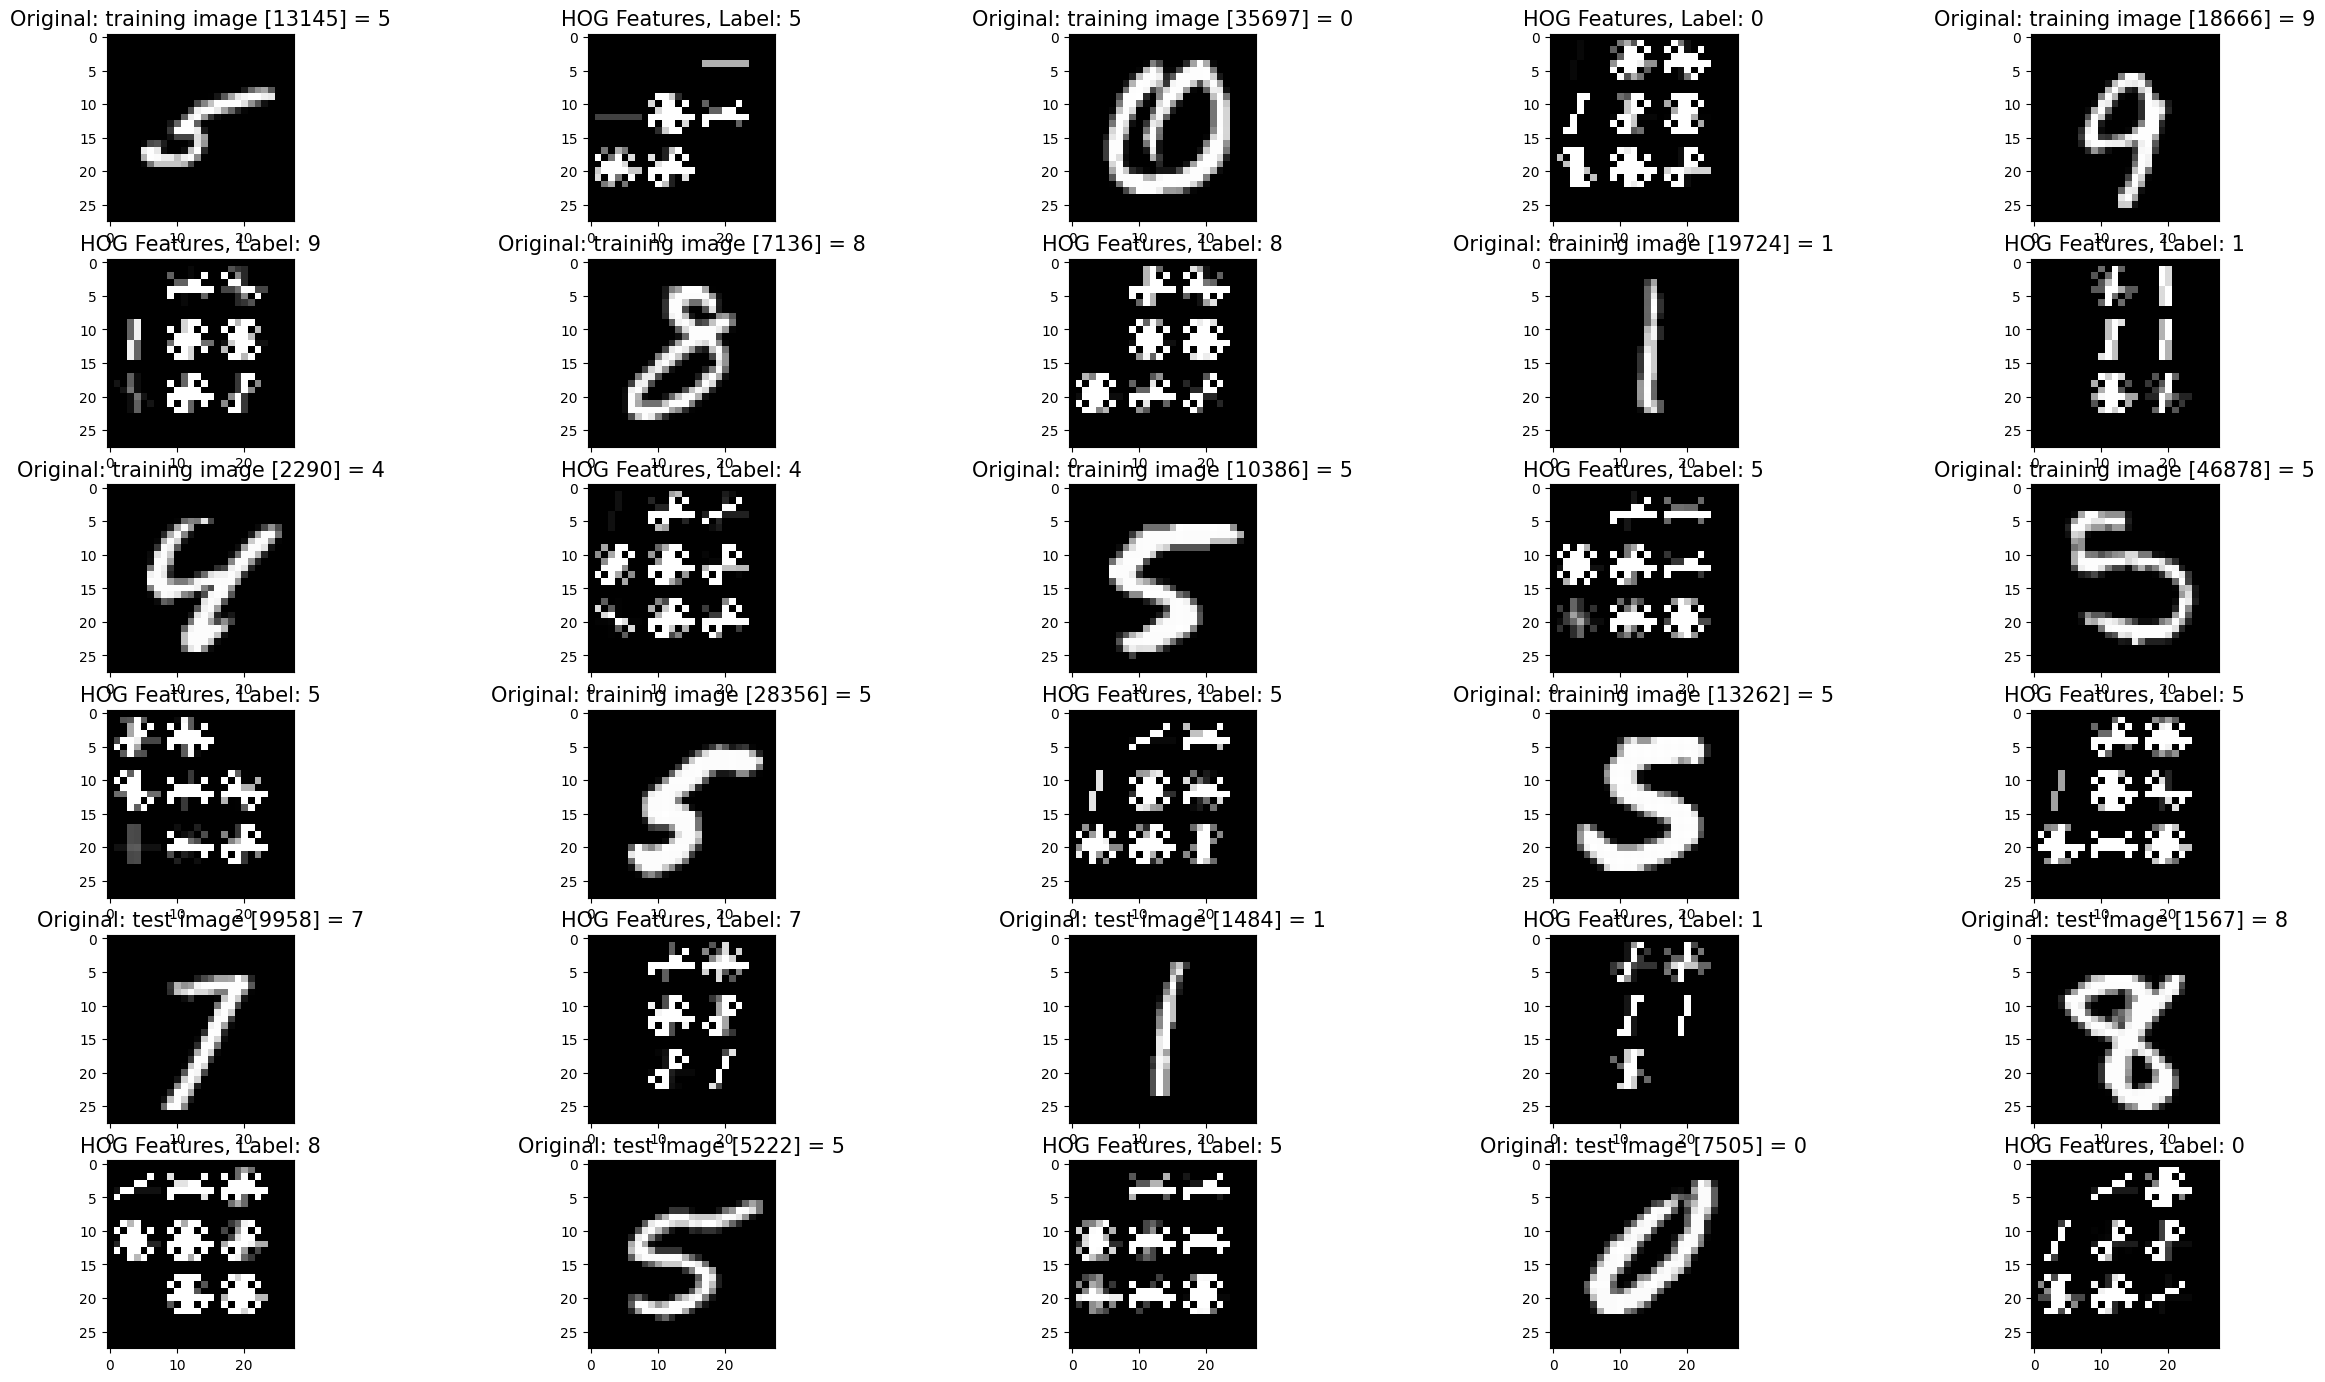

In [ ]:
#Verify Reading Dataset via MnistDataloader class

# set up inline plotting for Jupyter notebooks
%matplotlib inline
import random

# Define file paths for MNIST dataset
training_images_filepath = '/content/drive/MyDrive/MLproject/train-images.idx3-ubyte'
training_labels_filepath = '/content/drive/MyDrive/MLproject/train-labels.idx1-ubyte'
test_images_filepath = '/content/drive/MyDrive/MLproject/t10k-images.idx3-ubyte'
test_labels_filepath = '/content/drive/MyDrive/MLproject/t10k-labels.idx1-ubyte'

# function to show a list of images with their titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize=15)
        index += 1

# Load MNIST dataset using MnistDataloader class
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_validation, y_validation), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images with their HOG features
images_2_show = []
titles_2_show = []

# Show random training images
for i in range(0, 10):
    # Generate a random index in the training set
    r = random.randint(1, 48000)
    images_2_show.append(x_train[r])
    titles_2_show.append('Original: training image [' + str(r) + '] = ' + str(y_train[r]))

    # Compute HOG features and add them to the display
    hog_features = mnist_dataloader.compute_hog(x_train[r])
    images_2_show.append(hog_features)
    titles_2_show.append('HOG Features, Label: ' + str(y_train[r]))

# Show random test images
for i in range(0, 5):
    # Generate a random index in the test set
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('Original: test image [' + str(r) + '] = ' + str(y_test[r]))

    # Compute HOG features and add them to the display
    hog_features = mnist_dataloader.compute_hog(x_test[r])
    images_2_show.append(hog_features)
    titles_2_show.append('HOG Features, Label: ' + str(y_test[r]))

# Display the images and their titles using the show_images function
show_images(images_2_show, titles_2_show)

# **KNN**

In [ ]:
# Import necessary modules from scikit-learn for KNN classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

class KNNClassifier:
    def __init__(self, k):
        # Initialize the KNNClassifier with the specified number of neighbors (k)
        self.k = k
        # Create a KNeighborsClassifier model with the specified k
        self.model = KNeighborsClassifier(n_neighbors=k)

    def train(self, x_train, y_train):
        # Flatten the images for KNN classifier
        x_train_flatten = x_train.reshape(x_train.shape[0], -1)
        # Train the KNN model with the flattened training data
        self.model.fit(x_train_flatten, y_train)

    def predict(self, x_test):
        # Flatten the test images for prediction
        x_test_flatten = x_test.reshape(x_test.shape[0], -1)
        # Make predictions using the trained KNN model
        return self.model.predict(x_test_flatten)

# Instantiate the KNNClassifier with k = 3
knn_classifier = KNNClassifier(k = 3)

# Train the KNN model using the training data
knn_classifier.train(x_train, y_train)

# Make predictions on the validation set
y_pred = knn_classifier.predict(x_validation)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_validation, y_pred)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Make predictions on the test set
y_pred_test = knn_classifier.predict(x_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 97.04%
Test Accuracy: 96.74%


In [ ]:
# Hyperparameter tuning for KNN
for k_value in [1, 3, 5, 7]:
    # Instantiate KNNClassifier with the current k value
    knn_classifier = KNNClassifier(k = k_value)

    # Train the KNN model with the training data
    knn_classifier.train(x_train, y_train)

    # Make predictions on the validation set
    y_pred = knn_classifier.predict(x_validation)

    # Calculate and print accuracy for the current k value on the validation set
    accuracy = accuracy_score(y_validation, y_pred)
    print(f'KNN (k={k_value}) Validation Accuracy: {accuracy * 100:.2f}%')


KNN (k=1) Validation Accuracy: 96.82%
KNN (k=3) Validation Accuracy: 97.04%
KNN (k=5) Validation Accuracy: 96.88%
KNN (k=7) Validation Accuracy: 96.79%


# SVM


In [ ]:
# Import necessary modules from scikit-learn for SVM classification
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

class SVMClassifierWrapper:
    def __init__(self, kernel='rbf', C=1.0):
        # Initialize the SVMClassifierWrapper with specified kernel and regularization parameter (C)
        self.model = SVC(kernel = kernel, C = C)

    def train(self, x_train, y_train):
        # Flatten the images for SVM classifier
        x_train_flatten = x_train.reshape(x_train.shape[0], -1)
        # Train the SVM model with the flattened training data
        self.model.fit(x_train_flatten, y_train)

    def predict(self, x_test):
        # Flatten the test images for prediction
        x_test_flatten = x_test.reshape(x_test.shape[0], -1)
        # Make predictions using the trained SVM model
        return self.model.predict(x_test_flatten)

# Instantiate the SVMClassifierWrapper with a RBF kernel and C = 10
svm_classifier = SVMClassifierWrapper(kernel = 'rbf', C = 10)

# Train the SVM model using the training data
svm_classifier.train(x_train, y_train)

# Make predictions on the validation and test sets
y_svm_pred = svm_classifier.predict(x_validation)
y_svm_pred_test = svm_classifier.predict(x_test)

# Calculate accuracy for both validation and test sets
accuracy_svm = accuracy_score(y_validation, y_svm_pred)
accuracy_svm_test = accuracy_score(y_test, y_svm_pred_test)

# Print the accuracy results
print(f'SVM Validation Accuracy: {accuracy_svm * 100:.2f}%')
print(f'SVM Test Accuracy: {accuracy_svm_test * 100:.2f}%')

SVM Validation Accuracy: 98.34%
SVM Test Accuracy: 98.28%


In [ ]:
# Hyperparameter tuning for SVM
kernel = 'rbf'

# Iterate over different values of C (regularization parameter) for SVM
for C_value in [0.1, 1, 10]:
    # Instantiate SVMClassifierWrapper with the specified kernel and current C value
    svm_classifier = SVMClassifierWrapper(kernel = kernel, C = C_value)

    # Train the SVM model with the training data
    svm_classifier.train(x_train, y_train)

    # Make predictions on the validation set
    y_svm_pred = svm_classifier.predict(x_validation)

    # Calculate and print accuracy for the current C value on the validation set
    accuracy_svm = accuracy_score(y_validation, y_svm_pred)
    print(f'SVM (C = {C_value}) Validation Accuracy: {accuracy_svm * 100:.2f}%')


# **DT**

In [ ]:
# Import necessary modules from scikit-learn for Decision Tree classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define a custom DecisionTreeClassifierWrapper class
class DecisionTreeClassifierWrapper:
    def __init__(self, max_depth=None, min_samples_split=2):
        # Initialize the DecisionTreeClassifierWrapper with specified max_depth and min_samples_split
        self.model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)

    def train(self, x_train, y_train):
        # Flatten the images for Decision Tree classifier
        x_train_flatten = x_train.reshape(x_train.shape[0], -1)
        # Train the Decision Tree model with the flattened training data
        self.model.fit(x_train_flatten, y_train)

    def predict(self, x_test):
        # Flatten the test images for prediction
        x_test_flatten = x_test.reshape(x_test.shape[0], -1)
        # Make predictions using the trained Decision Tree model
        return self.model.predict(x_test_flatten)

# Instantiate the DecisionTreeClassifierWrapper with specified max_depth and min_samples_split
dt_classifier = DecisionTreeClassifierWrapper(max_depth = 20, min_samples_split = 2)

# Train the Decision Tree model using the training data
dt_classifier.train(x_train, y_train)

# Make predictions on the validation and test sets
y_dt_pred = dt_classifier.predict(x_validation)
y_dt_test = dt_classifier.predict(x_test)

# Calculate accuracy for both validation and test sets
accuracy_dt = accuracy_score(y_validation, y_dt_pred)
accuracy_dt_test = accuracy_score(y_test, y_dt_test)

# Print the accuracy results
print(f'Decision Tree Validation Accuracy: {accuracy_dt * 100:.2f}%')
print(f'Decision Tree Test Accuracy: {accuracy_dt_test * 100:.2f}%')

In [ ]:
# Hyperparameter tuning for Decision Tree classifier
for max_depth_value in [None, 10, 20]:
    for min_samples_split_value in [2, 5, 10]:
        # Instantiate DecisionTreeClassifierWrapper with current hyperparameter values
        dt_classifier = DecisionTreeClassifierWrapper(max_depth=max_depth_value, min_samples_split=min_samples_split_value)

        # Train the Decision Tree model with the training data
        dt_classifier.train(x_train, y_train)

        # Make predictions on the validation set
        y_dt_pred = dt_classifier.predict(x_validation)

        # Calculate and print accuracy for the current hyperparameter values on the validation set
        accuracy_dt = accuracy_score(y_validation, y_dt_pred)
        print(f'Decision Tree (max_depth={max_depth_value}, min_samples_split={min_samples_split_value}) Validation Accuracy: {accuracy_dt * 100:.2f}%')


# Proper Metrics
*  F1 measure (F-Score)
*   Precision measure
*   Recall measure


In [ ]:
# Calculate F1 score, precision, and recall for each classifier
from sklearn.metrics import f1_score, precision_score, recall_score

# KNN Classifier
f1_knn = f1_score(y_validation, y_pred, average='weighted')
precision_knn = precision_score(y_validation, y_pred, average='weighted')
recall_knn = recall_score(y_validation, y_pred, average='weighted')

# SVM Classifier
f1_svm = f1_score(y_validation, y_svm_pred, average='weighted')
precision_svm = precision_score(y_validation, y_svm_pred, average='weighted')
recall_svm = recall_score(y_validation, y_svm_pred, average='weighted')

# Decision Tree Classifier
f1_dt = f1_score(y_validation, y_dt_pred, average='weighted')
precision_dt = precision_score(y_validation, y_dt_pred, average='weighted')
recall_dt = recall_score(y_validation, y_dt_pred, average='weighted')

# Print F1 score, precision, and recall for each classifier

print('F1 Score:')
print(f'KNN: {f1_knn:.4f}')
print(f'SVM: {f1_svm:.4f}')
print(f'Decision Tree: {f1_dt:.4f}' + '\n')

print('Precision:')
print(f'KNN: {precision_knn:.4f}')
print(f'SVM: {precision_svm:.4f}')
print(f'Decision Tree: {precision_dt:.4f}' + '\n')

print('Recall:')
print(f'KNN: {recall_knn:.4f}')
print(f'SVM: {recall_svm:.4f}')
print(f'Decision Tree: {recall_dt:.4f}')

F1 Score:
KNN: 0.9703
SVM: 0.9834
Decision Tree: 0.8769

Precision:
KNN: 0.9706
SVM: 0.9834
Decision Tree: 0.8768

Recall:
KNN: 0.9704
SVM: 0.9834
Decision Tree: 0.8772


# Error analysis

In [ ]:
# Count and print the number of correctly and incorrectly classified instances for each classifier

# KNN Classifier
correct_knn = (y_pred == y_validation).sum()
incorrect_knn = len(y_validation) - correct_knn
print(f'KNN: Correctly classified = {correct_knn}, Incorrectly classified = {incorrect_knn}')

# SVM Classifier
correct_svm = (y_svm_pred == y_validation).sum()
incorrect_svm = len(y_validation) - correct_svm
print(f'SVM: Correctly classified = {correct_svm}, Incorrectly classified = {incorrect_svm}')

# Decision Tree Classifier
correct_dt = (y_dt_pred == y_validation).sum()
incorrect_dt = len(y_validation) - correct_dt
print(f'Decision Tree: Correctly classified = {correct_dt}, Incorrectly classified = {incorrect_dt}')

KNN: Correctly classified = 11645, Incorrectly classified = 355
SVM: Correctly classified = 11801, Incorrectly classified = 199
Decision Tree: Correctly classified = 10526, Incorrectly classified = 1474
